In [6]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import windrose
from datetime import datetime
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from windrose import WindroseAxes
import matplotlib.cm as cm
import matplotlib.ticker as tkr

# Enviroment Variables between 2016 and 2024

# Superficial current


## generating current data for a specific point

In [ ]:
# cordendas do ponto central
lat = -25.456
lon = -43.089

# pontos de teste
# latitude e longitude aproximadas da isóbata de 1000m no litoral de SC
sc_isobata_1000m = (-46, -26) # lon , lat
# lat e long talude bacia de santos
bacia_santos_talude = (-42.5, -23.5) # lon , lat


In [2]:
# depth limit

max_depth = 15  # depth in meters

In [ ]:
# # importando dados de corrente

# current_speed_ds = (
#     xr.open_dataset("D:/SARC_LISA_2024/01_dados_brutos/dados_de_reanalise/02_parametros_fisicos/corrente_waverys_AS_1979_2024/glorys_sarc.nc")
#     .sel(time=slice(datetime(2016, 1, 1), datetime(2024, 12, 31)))
#     .sel(latitude= lat, longitude=lon, method='nearest')
#     .sel(depth=max_depth, method='nearest')
# )

# # calculo da velocidade e direção da corrente
# u = current_speed_ds['uo'].values
# v = current_speed_ds['vo'].values

# current_speed = np.sqrt(u**2 + v**2)

# current_direction = (90 -(np.arctan2(v, u) * (180 / np.pi)) )% 360
# current_15m_df = pd.DataFrame({
#     'time': current_speed_ds['time'].values,
#     'current_speed': current_speed,
#     'current_direction': current_direction
# })

# # current_15m_df.to_csv("D:/SARC_LISA_2024/01_dados_brutos/dados_processados/corrente_waverys_AS_15m_2016_2024.csv")

## case 2 - Data importation

In [7]:
# importing processed current data
current_15m_df = pd.read_csv("D:/SARC_LISA_2024/01_dados_brutos/dados_processados/corrente_waverys_AS_15m_2016_2024.csv")
current_15m_df.set_index('time', inplace=True)

### general data

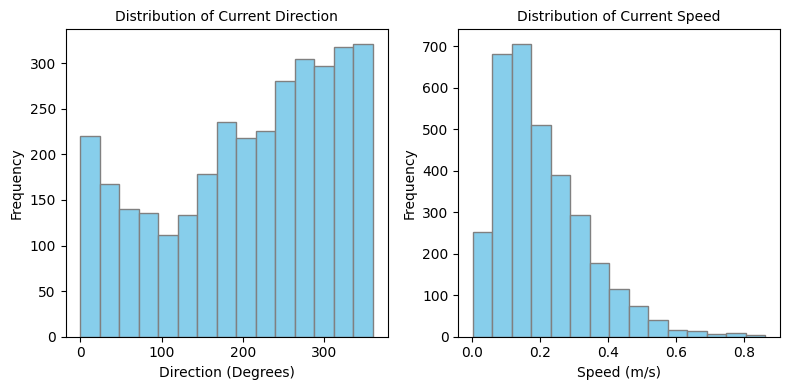

In [8]:
# plot data distribution

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))

# plot 1 : Current Direction
ax1.hist(current_15m_df['current_direction'], bins =15, color='skyblue', edgecolor = 'gray')
ax1.set_title('Distribution of Current Direction', fontsize=10)
ax1.set_xlabel('Direction (Degrees)', fontsize=10)
ax1.set_ylabel('Frequency', fontsize=10)

# plot 2 : Current Speed
ax2.hist(current_15m_df['current_speed'], bins=15, color='skyblue', edgecolor= 'gray')
ax2.set_title('Distribution of Current Speed', fontsize=10)
ax2.set_xlabel('Speed (m/s)', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)

# Optimization
plt.tight_layout() # Prevents labels from overlapping
plt.show()

In [32]:
print(f'te percentil 95°: {q_95:.2f} m/s')
print(f'the threshold was exceeded {current_15m_df[current_15m_df["current_speed"] > q_95].shape[0]} times.')
print(f'it represents {current_15m_df[current_15m_df["current_speed"] > q_95].shape[0] / current_15m_df.shape[0] * 100:.2f}% of the total data.')
# date on which the highest daily current velocity value was recorded
print(f'Date of highest current speed: {current_15m_df["current_speed"].idxmax()} with {current_15m_df["current_speed"].max():.2f} m/s')

te percentil 95°: 0.46 m/s
the threshold was exceeded 165 times.
it represents 5.02% of the total data.
Date of highest current speed: 2021-03-28 00:00:00 with 0.86 m/s


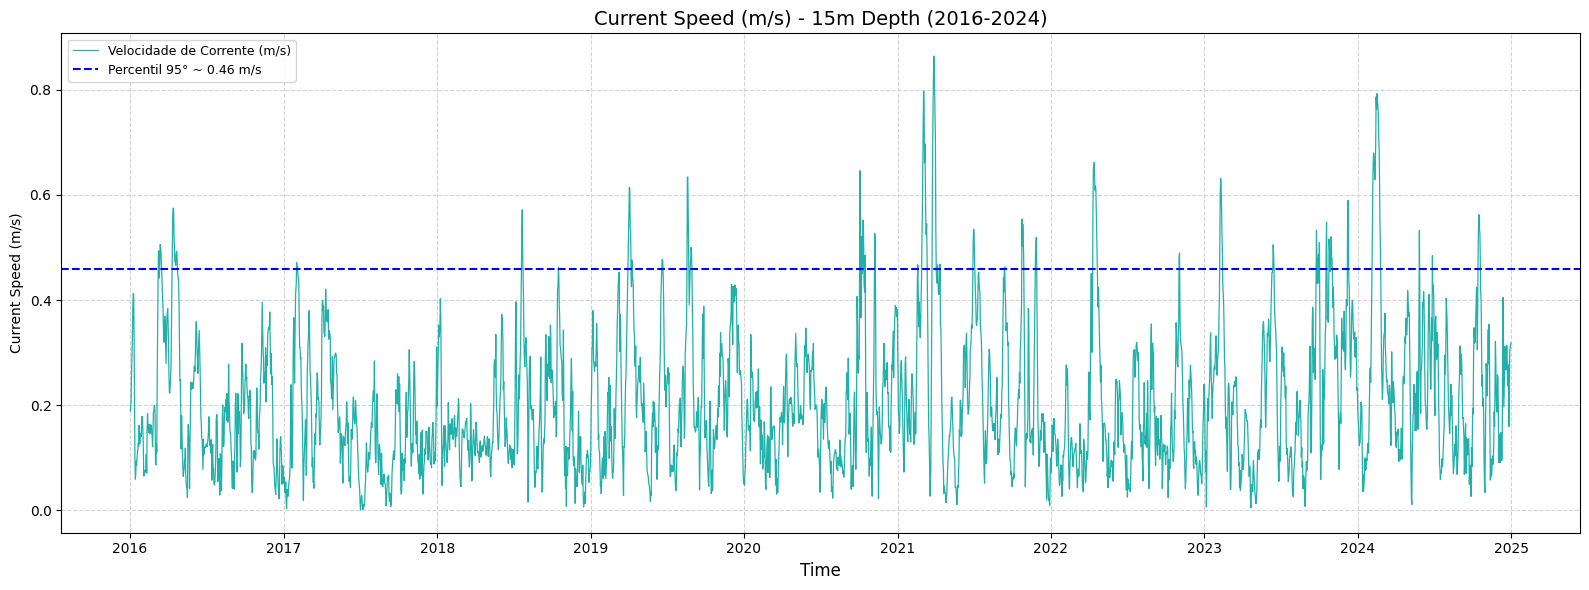

In [ ]:
q_95 = current_15m_df['current_speed'].quantile(0.95)
q_99 = current_15m_df['current_speed'].quantile(0.99)
# Plot the current speed time series
plt.figure(figsize=(16, 6))
plt.plot(current_15m_df.index, current_15m_df['current_speed'], label='Current Speed (m/s)', color='lightseagreen', linewidth=0.9)
#plt.plot(currents_df_9m.index, currents_df_9m['current_speed_9m'], label='Current Speed at 9m Depth', color='orange')
plt.axhline(y=q_95, color='royalblue', linestyle='--', label=f'95th Percentile ~ {q_95:.2f} m/s')
# plt.axhline(y=q_99, color='red', linestyle='--', label=f'Percentil 99° ~ {q_99:.2f} m/s')
plt.title('Current Speed (m/s) - 15m Depth (2016-2024)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Current Speed (m/s)')
plt.grid(
    linestyle = '--',
    color = 'lightgray'
)
plt.legend(loc = 'upper left',
        #    bbox_to_anchor = (1,1.2),
           fontsize = 9)
plt.tight_layout()

In [40]:
def plot_extreme_events(df, var, quantile, var_label):
    # 1. Filtering extreme data
    extreme_values = df[df[var] > quantile]
    
    # 2. Groups
    extreme_by_month = extreme_values.groupby(extreme_values.index.month).count()
    extreme_by_year = extreme_values.groupby(extreme_values.index.year).count()
    
    # 3. Figure configuration (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    month_label = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'set', 'oct', 'nov', 'dec']

    # --- SUBPLOT 1: MONTHLY ---
    bars1 = ax1.bar(extreme_by_month.index, extreme_by_month[var].values, color='skyblue', width=0.8)
    ax1.set_title(f'{var_label} extreme events per month', fontsize=13, weight='bold')
    ax1.set_xlabel('month')
    ax1.set_ylabel('Number of Occurrences')
    ax1.set_xticks(extreme_by_month.index)
    ax1.set_xticklabels([month_label[i-1] for i in extreme_by_month.index])
    ax1.grid(axis='y', linestyle="--", color="lightgray", alpha=0.7)

    # --- SUBPLOT 2: ANUAL ---
    bars2 = ax2.bar(extreme_by_year.index, extreme_by_year[var].values, color='skyblue', width=0.8)
    ax2.set_title(f'{var_label} extreme events per year', fontsize=13, weight='bold')
    ax2.set_xlabel('Year')
    ax2.set_xticks(extreme_by_year.index)
    ax2.grid(axis='y', linestyle="--", color="lightgray", alpha=0.7)

    # 4. Auxiliary function for adding numerical labels to the bars.
    def add_labels(ax, bars):
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval + (yval*0.01), 
                    int(yval), ha='center', va='bottom', fontsize=10)

    add_labels(ax1, bars1)
    add_labels(ax2, bars2)

    # 5. Final adjustments
    fig.suptitle(f'Extreme Value Analysis: {var_label} (Quantile > {quantile:.2f}) m/s', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

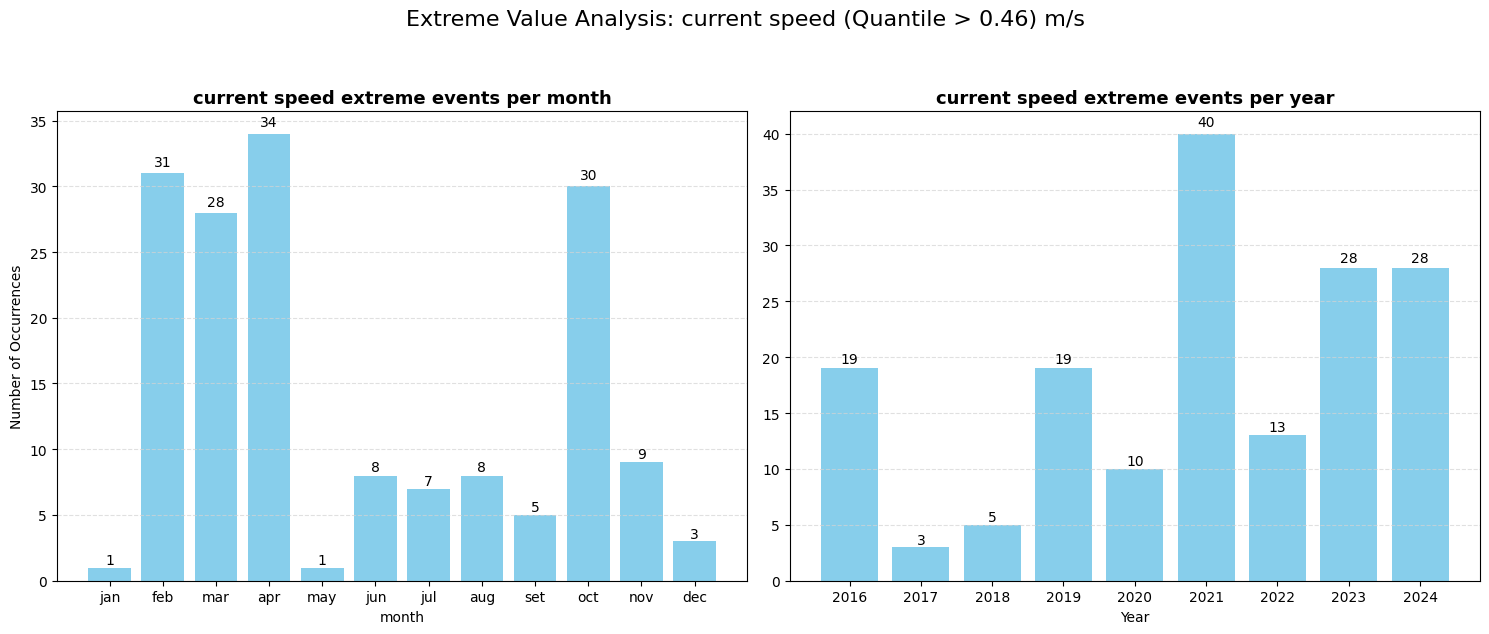

In [41]:
plot_extreme_events(current_15m_df, 'current_speed', q_95, 'current speed')

#### Plot rose for general surface current data

Text(0.5, 1.0, 'Superficial Current: Direction and Speed (2016-2024)')

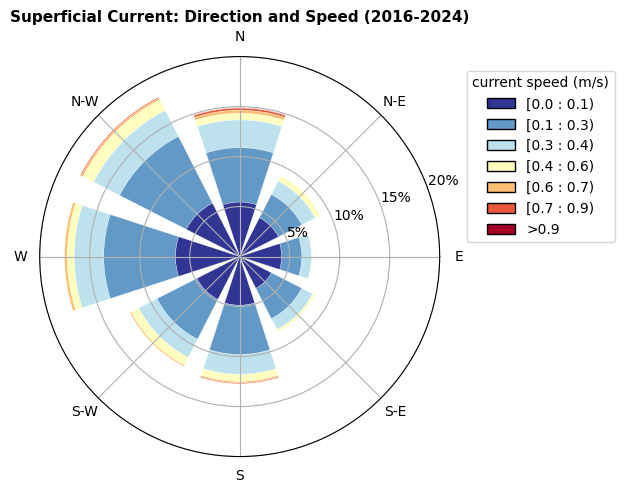

In [129]:
# plot windrose current
fig = plt.figure(figsize=(5,5))

ax = WindroseAxes.from_ax(fig=fig)
# ax.set_theta_zero_location("N")
# ax.set_theta_direction(-1)

ax.bar(current_15m_df['current_direction'], current_15m_df['current_speed'], # direction, magnitude
        normed=True, bins = 7, nsector=8,
        cmap = plt.get_cmap('RdYlBu_r'), # color scheeme
        edgecolor = 'white', lw=0.2) # add a line between blocks, for clarity

ax.tick_params(axis='both', which='major', labelsize=10)
ax.legend(title = "current speed (m/s)",
          loc= 'center left', 
          decimal_places=1,
          bbox_to_anchor=(1.05, 0.75),
          fontsize=10)

ax.set_rlabel_position(20)
ax.set_yticks([5,10,15,20])
ax.yaxis.set_major_formatter(tkr.FormatStrFormatter('%.0f%%'))

plt.title("Superficial Current: Direction and Speed (2016-2024)", fontsize=11, weight = 'bold')


### calculate limiar to define extreme events

In [10]:
# calculate extreme currents (95th percentile)
speed_threshold = current_15m_df['current_speed'].quantile(0.95) # 95th percentile

strong_currents_df = current_15m_df[current_15m_df['current_speed'] >= speed_threshold] # filtering strong currents

# set indexes
strong_currents_df.index = pd.to_datetime(strong_currents_df.index)
current_15m_df.index = pd.to_datetime(current_15m_df.index)

In [22]:
# basic statistics
max_c_speed = strong_currents_df['current_speed'].max()
min_c_speed = strong_currents_df['current_speed'].min()
mean_speed = strong_currents_df['current_speed'].mean()

diference_speed = max_c_speed - min_c_speed

print(f"Max Speed: {max_c_speed:.2f} m/s")
print(f"Min Speed: {min_c_speed:.2f} m/s")
print(f"Mean Speed: {mean_speed:.2f} m/s")
print(f"Difference Speed: {diference_speed:.2f} m/s")

Max Speed: 0.86 m/s
Min Speed: 0.46 m/s
Mean Speed: 0.56 m/s
Difference Speed: 0.40 m/s


Text(0, 0.5, 'Velocidade da corrente (m/s)')

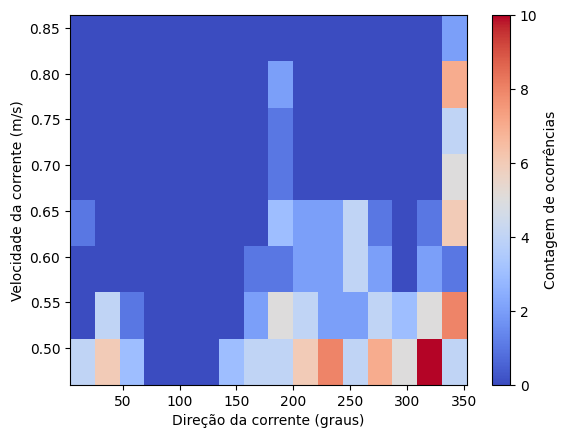

In [ ]:
plt.hist2d(strong_currents_df['current_direction'], strong_currents_df['current_speed'],
           bins=[16, 8],
           cmap='coolwarm'
              )
plt.colorbar(label='number of occurrences')
plt.xlabel('Current Direction (graus)')
plt.ylabel('Current Speed (m/s)')

Text(0.5, 1.0, 'Extreme current: Direction and Speed (2016-2024)')

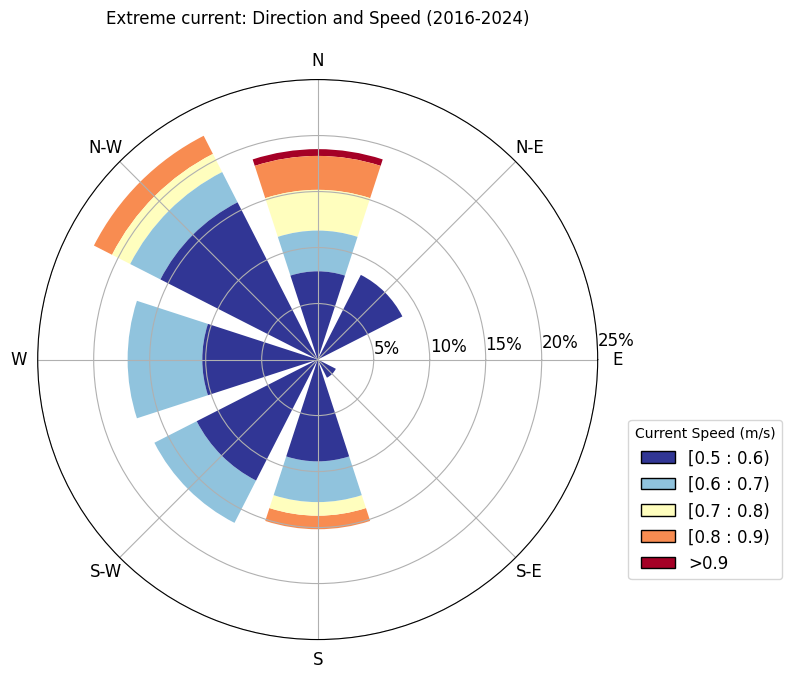

In [16]:
# plot windrose for extreme currents

fig = plt.figure(figsize=(7,7))
right_rectangle = [0,0,0.8,0.8] # [left, bottom, width, height]
ax = WindroseAxes(fig, right_rectangle)
fig.add_axes(ax)

ax.bar(strong_currents_df['current_direction'], strong_currents_df['current_speed'], # direction, magnitude
        normed=True, bins = 5, nsector=8,
        cmap = plt.get_cmap('RdYlBu_r')) 

ax.tick_params(axis='both', which='major', labelsize=12)
# radial labels formatting
ax.legend(loc= 'center left', decimal_places=1, title="Current Speed (m/s)",
          bbox_to_anchor=(1.04, 0.25), fontsize=12)

ax.set_rlabel_position(2) # radial label position
ax.set_yticks([5,10,15,20,25])
ax.yaxis.set_major_formatter(tkr.FormatStrFormatter('%.0f%%'))

plt.title("Extreme current: Direction and Speed (2016-2024)",pad= 20, fontsize=12)

### separate data per season

In [18]:
# seasonal analysis
# season definition function
def define_season(date):
    m = date.month
    d = date.day

    if (m == 12 and d >= 21) or (m < 3) or (m == 3 and d < 20):
        return 'summer'      # Verão
    elif (m == 3 and d >= 20) or (m < 6) or (m == 6 and d < 21):
        return 'autumn'      # Outono
    elif (m == 6 and d >= 21) or (m < 9) or (m == 9 and d < 23):
        return 'winter'      # Inverno
    else:
        return 'spring'      # Primavera

In [20]:
# applying season function

strong_currents_df['season'] = strong_currents_df.index.to_series().apply(define_season)

c_summer = strong_currents_df[strong_currents_df['season'] == 'summer']
c_autumn = strong_currents_df[strong_currents_df['season'] == 'autumn']
c_winter = strong_currents_df[strong_currents_df['season'] == 'winter']
c_spring = strong_currents_df[strong_currents_df['season'] == 'spring']

C:\Users\locfa\AppData\Local\Temp\ipykernel_33340\156409139.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strong_currents_df['season'] = strong_currents_df.index.to_series().apply(define_season)


In [25]:
seasons = {'Summer': c_summer, 'Autumn': c_autumn, 'Winter': c_winter, 'Spring': c_spring}
for s in seasons:
    print(f"{s} - Maximum current speed (m/s): {seasons[s]['current_speed'].max()}")

Summer - Maximum current speed (m/s): 0.7971771158717851
Autumn - Maximum current speed (m/s): 0.86397765494524
Winter - Maximum current speed (m/s): 0.634296806080701
Spring - Maximum current speed (m/s): 0.6459253879790632


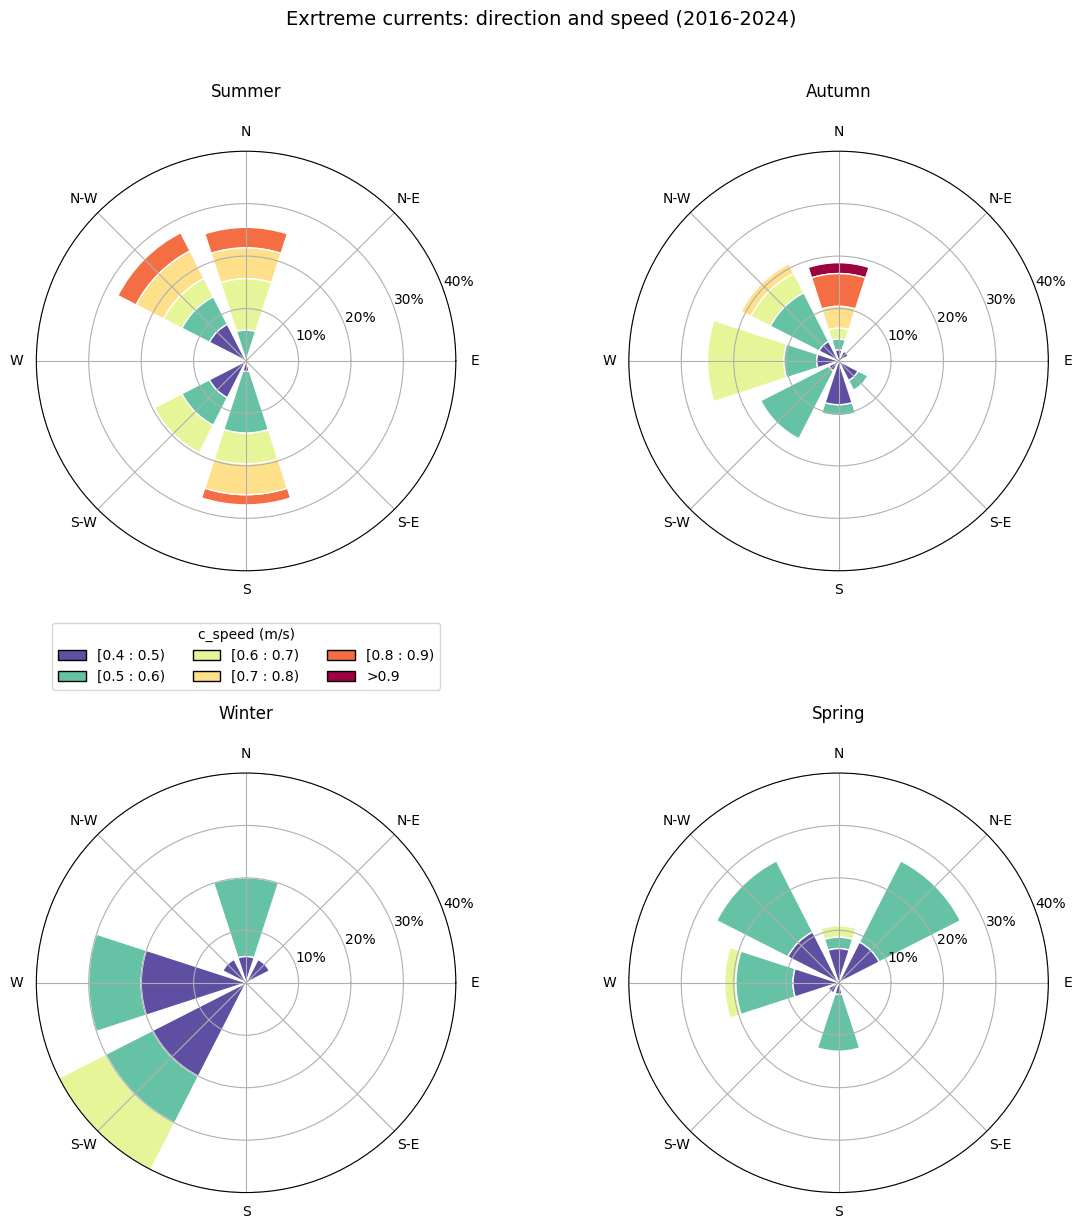

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), subplot_kw=dict(projection='windrose'))

seasons = {'Summer': c_summer, 'Autumn': c_autumn, 'Winter': c_winter, 'Spring': c_spring}
bins = np.linspace(min_c_speed-0.06, max_c_speed, num=6)

# --- STANDARDIZATION CONFIGURATION ---
# Define the maximum value of the radial scale (e.g., 25%).
r_max_limit = 40 
# Define where the circles (grids) should appear
r_ticks = [10, 20, 30, 40]

for i, (season, data) in enumerate(seasons.items()):
    ax = axes.flatten()[i]
    
    ax.bar(data['current_direction'], data['current_speed'],
           bins=bins,
           normed=True, # Ensures the calculation is in percentage.
           nsector=8,
           edgecolor='white', 
           cmap=cm.Spectral_r)
    
    ax.set_title(season, fontsize=12, pad=20)
    
    # Standardization of radial limits and ticks
    ax.set_ylim(0, r_max_limit) # Forces all axes to have the same size
    ax.set_yticks(r_ticks)      # Forces the same grid lines
    
    # Formatting of labels
    ax.set_rlabel_position(20)
    ax.yaxis.set_major_formatter(tkr.FormatStrFormatter('%2.0f%%')) # Adds the % symbol

# Adjustment of the legend (moved outside to avoid overlap)
axes.flatten()[0].legend(title="c_speed (m/s)", 
                         loc='lower center', 
                         bbox_to_anchor=(0.5, -0.3), 
                         ncol=3)


fig.suptitle('Exrtreme currents: direction and speed (2016-2024)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Significant Wave height

In [47]:
# importing wave data
wave_ds = xr.open_dataset("D:/SARC_LISA_2024/01_dados_brutos/dados_de_reanalise/02_parametros_fisicos/centroid_point_data/wave_height_2016_2024/reanalysis-era5-single-levels-timeseries-wavdj3m5fj6.nc")
wave_df = wave_ds.to_dataframe().reset_index().set_index('valid_time')

# print columns names
print(wave_df.columns)

Index(['mwd', 'swh', 'latitude', 'longitude'], dtype='object')


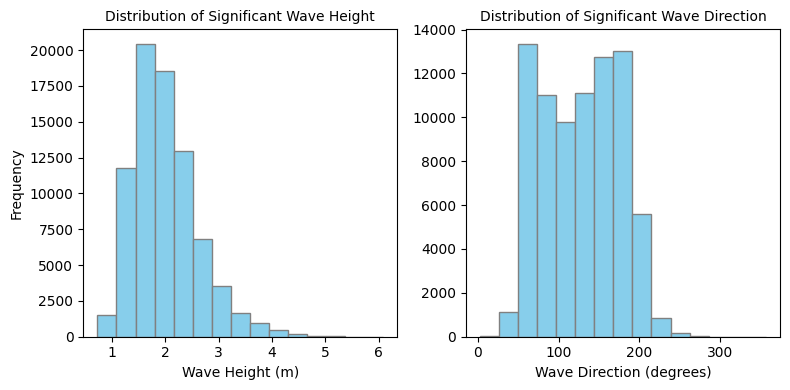

In [52]:
# plot data distribution

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))

# plot 1 : Wave Height
ax1.hist(wave_df['swh'], bins =15, color='skyblue', edgecolor = 'gray')
ax1.set_title('Distribution of Significant Wave Height', fontsize=10)
ax1.set_xlabel('Wave Height (m)', fontsize=10)
ax1.set_ylabel('Frequency', fontsize=10)

# plot 2 : Wave direction
ax2.hist(wave_df['mwd'], bins=15, color='skyblue', edgecolor= 'gray')
ax2.set_title('Distribution of Significant Wave Direction', fontsize=10)
ax2.set_xlabel('Wave Direction (degrees)', fontsize=10)
# ax2.set_ylabel('Frequency', fontsize=10)

# Optimization
plt.tight_layout() # Prevents labels from overlapping
plt.show()

In [50]:
# define wave height threshold (99th percentile)
q99_Hs = wave_df['swh'].quantile(0.99)

In [49]:
print(f'te percentil 95°: {q99_Hs:.2f} m')
print(f'the threshold was exceeded {wave_df[wave_df["swh"] > q99_Hs].shape[0]} times.')
print(f'it represents {wave_df[wave_df["swh"] > q99_Hs].shape[0] / wave_df.shape[0] * 100:.2f}% of the total data.')
# date on which the highest daily current velocity value was recorded
print(f'Date of highest wave height: {wave_df["swh"].idxmax()} with {wave_df["swh"].max():.2f} m')

te percentil 95°: 3.94 m
the threshold was exceeded 790 times.
it represents 1.00% of the total data.
Date of highest wave height: 2022-05-18 23:00:00 with 6.08 m


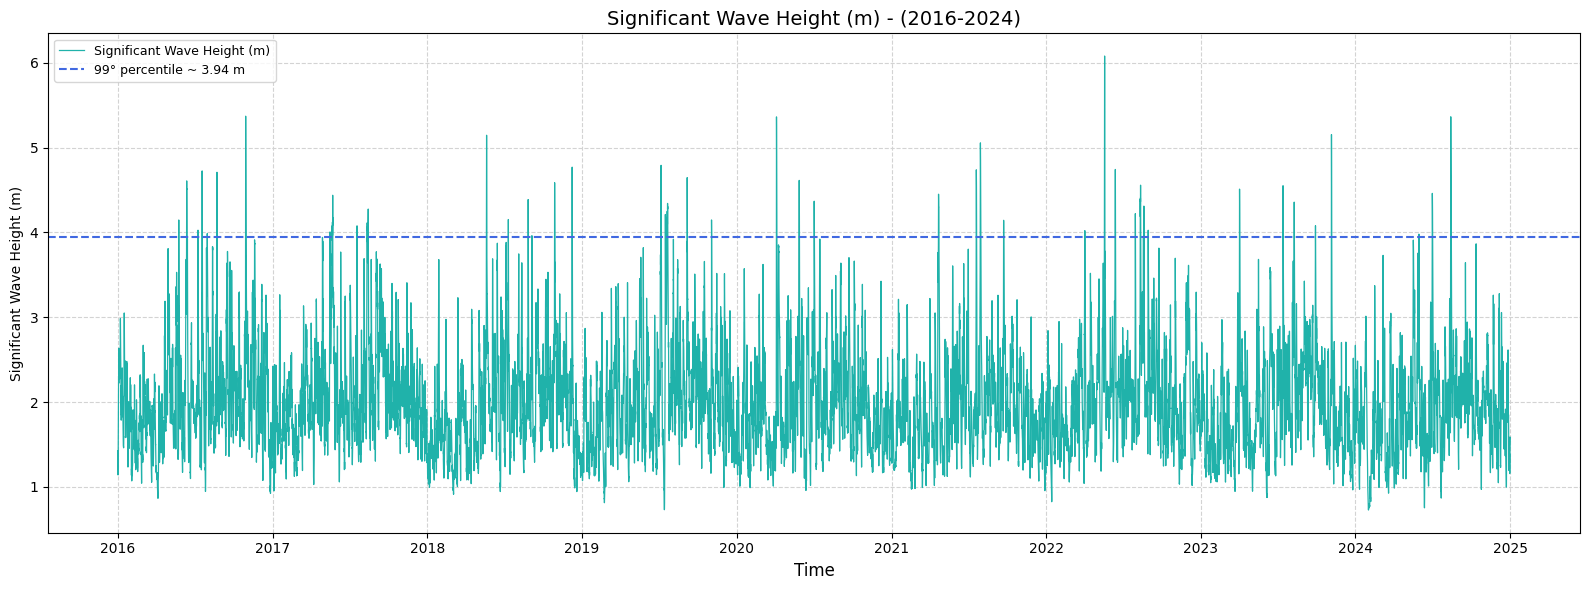

In [54]:
# plot wave height time series
plt.figure(figsize=(16, 6))
plt.plot(wave_df.index, wave_df['swh'], label='Significant Wave Height (m)', color='lightseagreen', linewidth=0.9)
plt.axhline(y=q99_Hs, color='royalblue', linestyle='--', label=f'99° percentile ~ {q99_Hs:.2f} m')
plt.title('Significant Wave Height (m) - (2016-2024)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Significant Wave Height (m)')
plt.grid(
    linestyle = '--',
    color = 'lightgray'
)
plt.legend(loc = 'upper left',
        #    bbox_to_anchor = (1,1.2),
              fontsize = 9)
plt.tight_layout()
plt.show()  

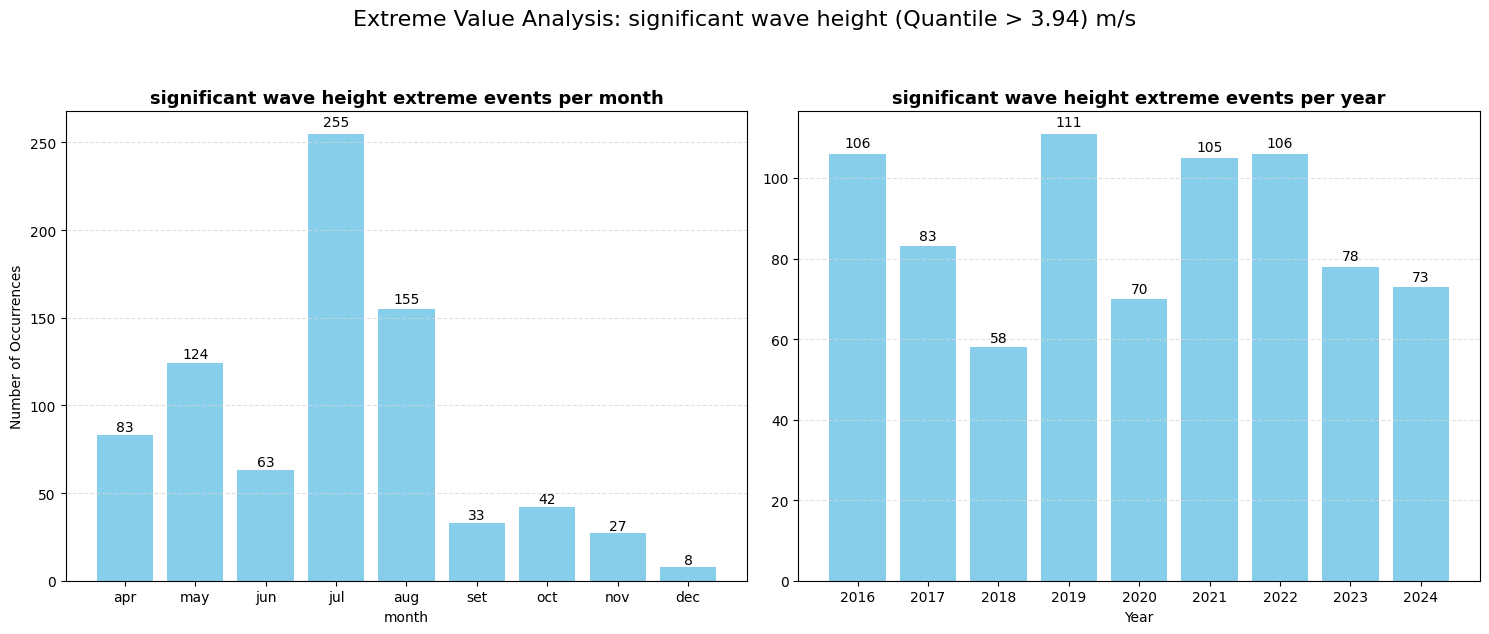

In [55]:
plot_extreme_events(wave_df, 'swh', q99_Hs, 'significant wave height')

### plot waverose for general wave data

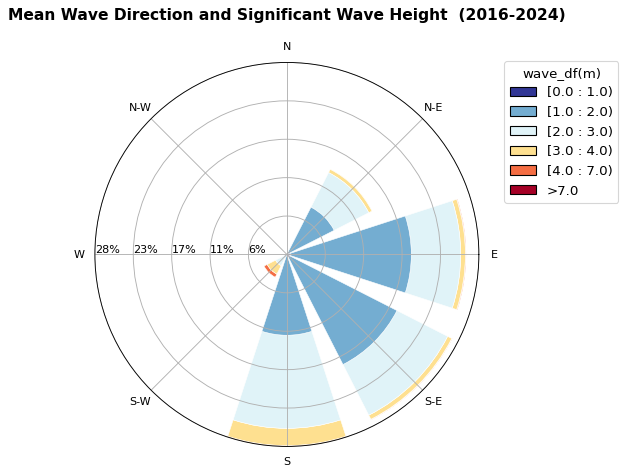

In [73]:
# plot wave roseplot
ax = windrose.WindroseAxes.from_ax(figsize=(6,6))

# Define bins for wave height
wave_bins = [0, 1, 2, 3, 4, np.ceil(wave_df['swh'].max())]
wave_labels = ['0-1', '1-2', '2-3', '3-4', '4-5', '>5']

ax.bar(
    wave_df['mwd'],
    wave_df['swh'],
    bins=wave_bins,
    nsector=8,
    normed=True,
    opening=0.8,
    edgecolor='white',
    linewidth=0.5,
    cmap=plt.cm.RdYlBu_r
)

legend = ax.set_legend(title='wave_df(m)',
              loc='upper right', 
              bbox_to_anchor=(1.36, 1), 
              labels=wave_labels,
              fontsize=12)
plt.setp(legend.get_title(), fontsize=12) # Adjust legend title font size
# set legend text font size
for text in legend.get_texts():
    text.set_fontsize(12)
ax.set_rlabel_position(180)
ax.yaxis.set_major_formatter(tkr.FormatStrFormatter('%.0f%%')) # adds the % symbol

# set title
ax.set_title('Mean Wave Direction and Significant Wave Height  (2016-2024)', weight='bold', pad=20, fontsize=14)

plt.show()

### define threshold for wave height


In [75]:
q99_Hs = wave_df['swh'].quantile(0.99)
extreme_wave_df = wave_df[wave_df['swh'] >= q99_Hs] # filtering extreme wave heights

min_w_height = extreme_wave_df['swh'].min()
max_w_height = extreme_wave_df['swh'].max()

print(f"Max extreme Wave Height: {max_w_height:.2f} m")
print(f"Min extreme Wave Height: {min_w_height:.2f} m")


Max extreme Wave Height: 6.08 m
Min extreme Wave Height: 3.94 m


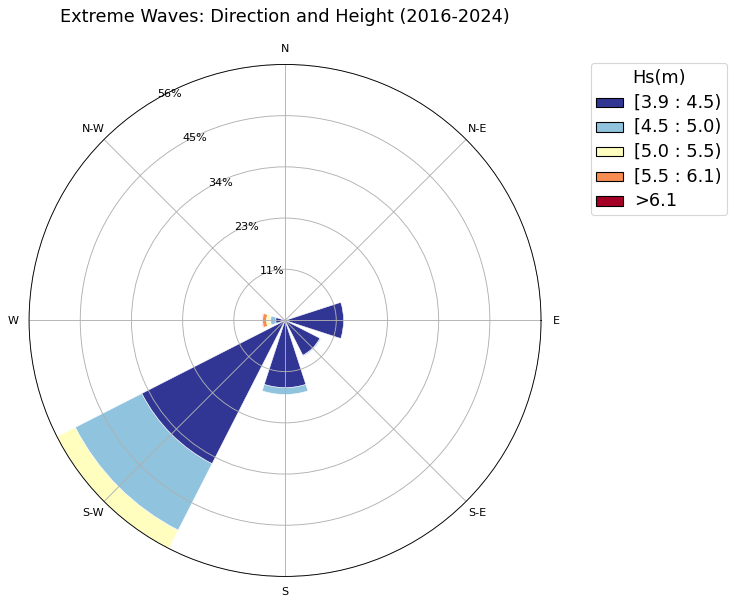

In [77]:
# Wind rose plot for wave direction and height
ax = windrose.WindroseAxes.from_ax(figsize=(8, 8))


ax.bar(
    extreme_wave_df['mwd'],
    extreme_wave_df['swh'],
    bins=5,
    nsector=8,
    normed=True,
    opening=0.8,
    edgecolor='white',
    linewidth=0.5,
    cmap=plt.cm.RdYlBu_r
)

legend = ax.set_legend(title='Hs(m)',
              loc='upper right', 
              bbox_to_anchor=(1.36, 1), 
              labels=wave_labels,
              fontsize=12)

# Ajustar título
plt.setp(legend.get_title(), fontsize=16)

# Ajustar rótulos
for text in legend.get_texts():
    text.set_fontsize(16)
ax.set_rlabel_position(120)
ax.yaxis.set_major_formatter(tkr.FormatStrFormatter('%.0f%%'))
ax.set_title('Extreme Waves: Direction and Height (2016-2024)', pad=20, fontsize=16)
# ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
plt.show()

In [109]:
extreme_wave_df['season'] = extreme_wave_df.index.to_series().apply(define_season)

w_summer = extreme_wave_df[extreme_wave_df['season'] == 'summer']
w_autumn = extreme_wave_df[extreme_wave_df['season'] == 'autumn']
w_winter = extreme_wave_df[extreme_wave_df['season'] == 'winter']
w_spring = extreme_wave_df[extreme_wave_df['season'] == 'spring']

C:\Users\locfa\AppData\Local\Temp\ipykernel_33340\1129650623.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extreme_wave_df['season'] = extreme_wave_df.index.to_series().apply(define_season)


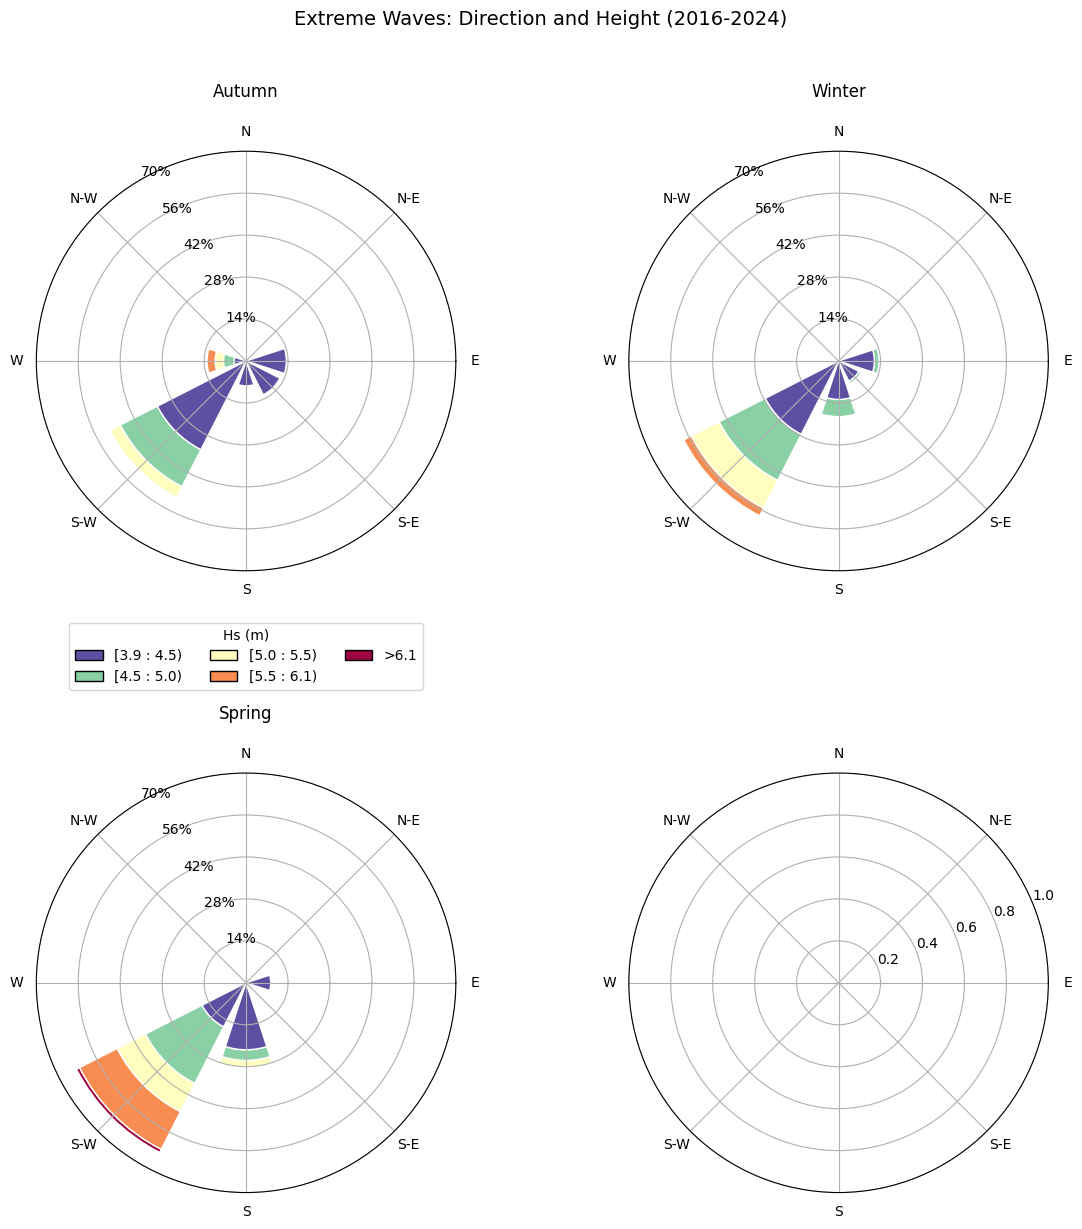

In [110]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), subplot_kw=dict(projection='windrose'))
seasons = {'Autumn': w_autumn, 'Winter': w_winter, 'Spring': w_spring}

# --- STANDARDIZATION CONFIGURATION ---
# Define the maximum value of the radial scale (e.g., 25%).
r_max_limit =70
# Define where the circles (grids) should appear
r_ticks = [14, 28, 42, 56, 70]
for i, (season, data) in enumerate(seasons.items()):
    ax = axes.flatten()[i]
    
    ax.bar(data['mwd'], data['swh'],
           bins=5,
           normed=True, # Ensures the calculation is in percentage.
           nsector=8,
           edgecolor='white', 
           cmap=cm.Spectral_r)
    
    ax.set_title(season, fontsize=12, pad=20)
    
    # Standardization of radial limits and ticks
    ax.set_ylim(0, r_max_limit) # Forces all axes to have the same size
    ax.set_yticks(r_ticks)      # Forces the same grid lines
    
    # Formatting of labels
    ax.set_rlabel_position(120)
    ax.yaxis.set_major_formatter(tkr.FormatStrFormatter('%2.0f%%')) # Adds the % symbol
# Adjustment of the legend (moved outside to avoid overlap)
axes.flatten()[0].legend(title="Hs (m)",
                            loc='lower center', 
                            bbox_to_anchor=(0.5, -0.3), 
                            ncol=3)
fig.suptitle('Extreme Waves: Direction and Height (2016-2024)', fontsize=14, y=1.02)
plt.tight_layout()

In [83]:
for s in seasons:
    print(f"{s} - Maximum wave height (m): {seasons[s]['swh'].max()}")

Autumn - Maximum wave height (m): 6.079657077789307
Winter - Maximum wave height (m): 5.363559722900391
Spring - Maximum wave height (m): 5.370546340942383


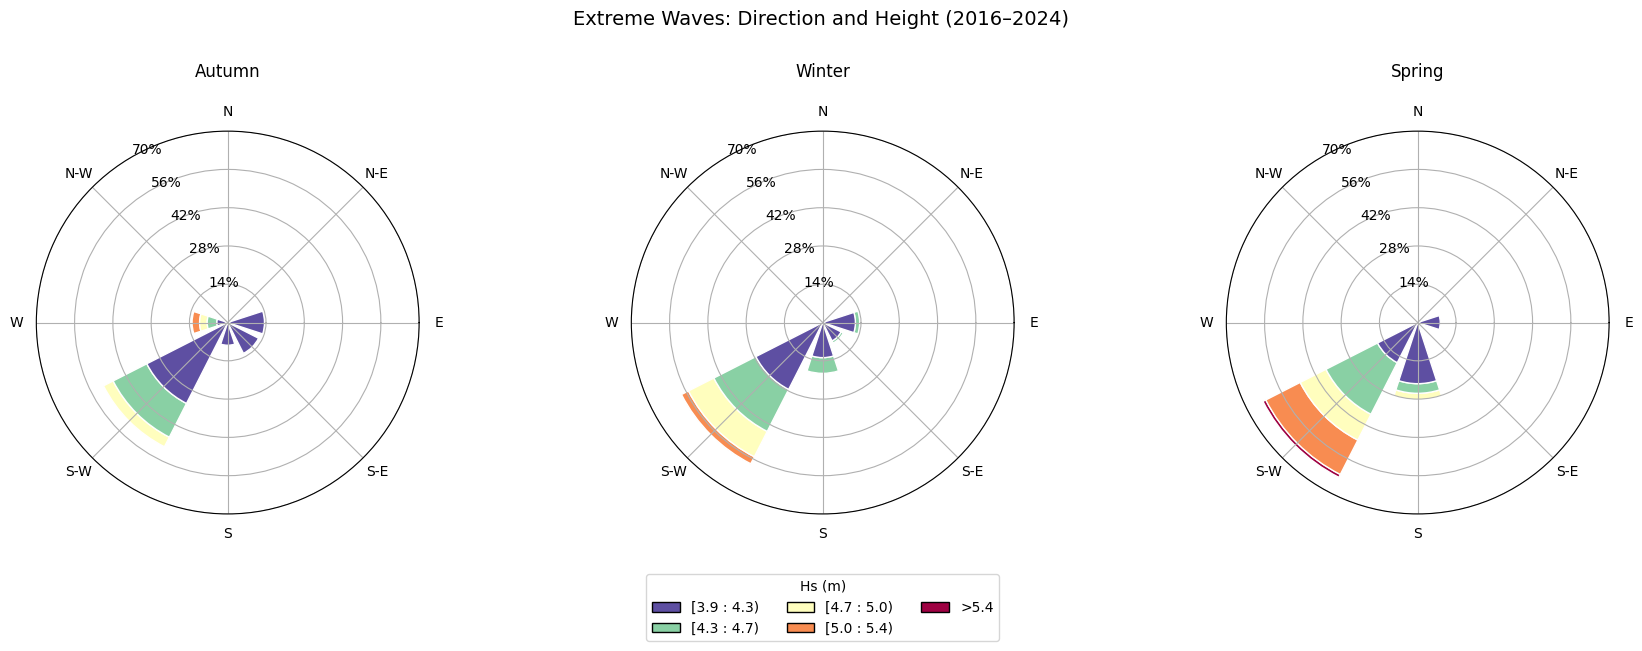

In [106]:
fig, axes = plt.subplots(
    1, 3,
    figsize=(18, 6),
    subplot_kw=dict(projection='windrose')
)

seasons = {
    'Autumn': w_autumn,
    'Winter': w_winter,
    'Spring': w_spring
}

# --- STANDARDIZATION CONFIGURATION ---
r_max_limit = 70
r_ticks = [14, 28, 42, 56, 70]

for ax, (season, data) in zip(axes, seasons.items()):
    
    ax.bar(
        data['mwd'],
        data['swh'],
        bins=5,
        normed=True,      # Percentage
        nsector=8,
        edgecolor='white',
        cmap=cm.Spectral_r
    )
    
    ax.set_title(season, fontsize=12, pad=20)

    # Radial standardization
    ax.set_ylim(0, r_max_limit)
    ax.set_yticks(r_ticks)

    # Label formatting
    ax.set_rlabel_position(120)
    ax.yaxis.set_major_formatter(
        tkr.FormatStrFormatter('%2.0f%%')
    )

# Legend (use first axis only)
axes[1].legend(
    title="Hs (m)",
    loc='lower center',
    bbox_to_anchor=(0.5, -0.35),
    ncol=3
)

fig.suptitle(
    'Extreme Waves: Direction and Height (2016–2024)',
    fontsize=14,
    y=1.05
)

plt.tight_layout()
plt.show()


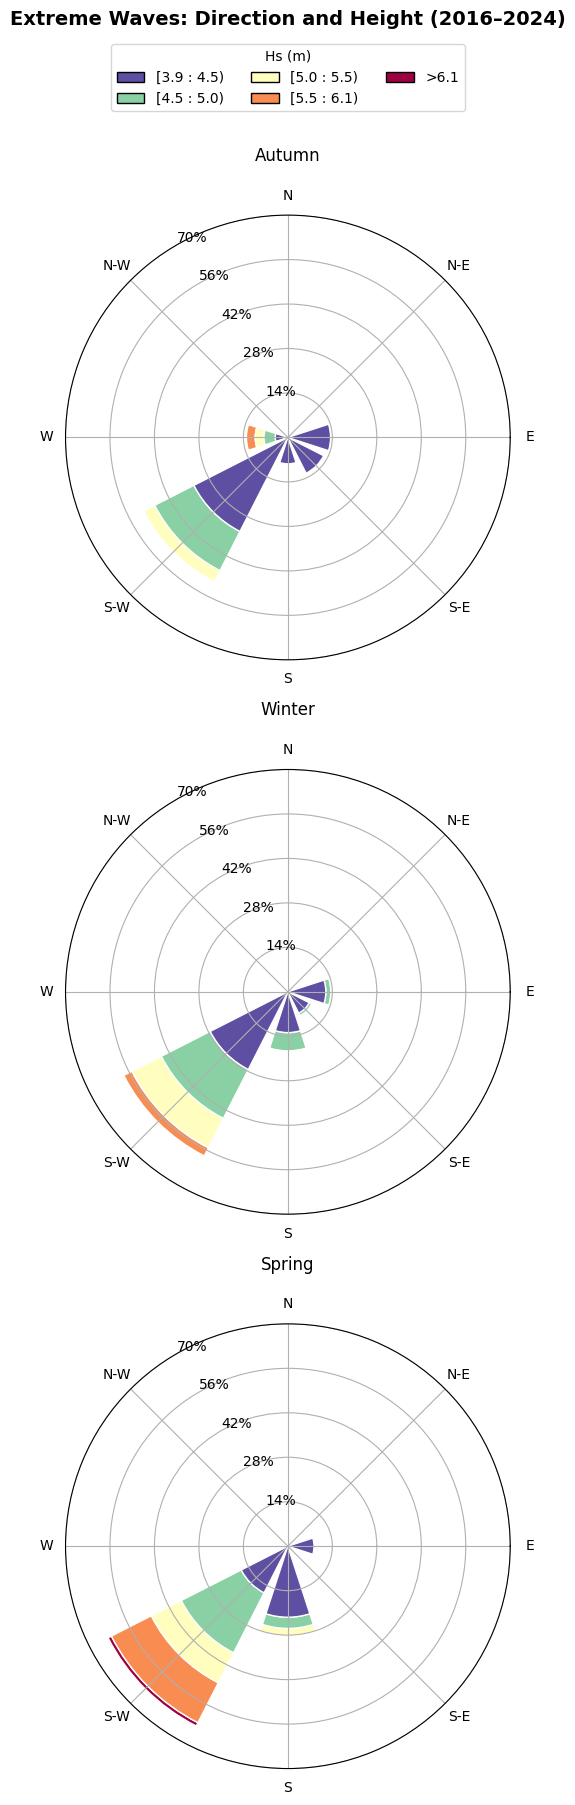

In [108]:
fig, axes = plt.subplots(
    3, 1,
    figsize=(6, 18),
    subplot_kw=dict(projection='windrose')
)

seasons = {
    'Autumn': w_autumn,
    'Winter': w_winter,
    'Spring': w_spring
}

# --- STANDARDIZATION CONFIGURATION ---
r_max_limit = 70
r_ticks = [14, 28, 42, 56, 70]

for ax, (season, data) in zip(axes, seasons.items()):
    
    ax.bar(
        data['mwd'],
        data['swh'],
        bins=5,
        normed=True,      # Percentage
        nsector=8,
        edgecolor='white',
        cmap=cm.Spectral_r
    )
    
    ax.set_title(season, fontsize=12, pad=20)

    # Radial standardization
    ax.set_ylim(0, r_max_limit)
    ax.set_yticks(r_ticks)

    # Label formatting
    ax.set_rlabel_position(120)
    ax.yaxis.set_major_formatter(
        tkr.FormatStrFormatter('%2.0f%%')
    )

# Legend (use first axis only)
axes[0].legend(
    title="Hs (m)",
    loc='upper center',
    bbox_to_anchor=(0.5, 1.4),
    ncol=3
)

fig.suptitle(
    'Extreme Waves: Direction and Height (2016–2024)',
    fontsize=14,
    y= 1,
    weight='bold'
)

plt.tight_layout()
plt.show()


# Wind - 10 m

In [111]:
# data importation
wind_ds =  xr.open_dataset("D:/SARC_LISA_2024/01_dados_brutos/dados_de_reanalise/02_parametros_fisicos/centroid_point_data/wind_velocity_2016_2024/reanalysis-era5-single-levels-timeseries-sfc8oghmqym.nc")

In [119]:
wind_df = wind_ds.to_dataframe().reset_index().set_index('valid_time')

# speed calculation
wind_df['wind_speed'] = np.sqrt(wind_df['u10']**2 + wind_df['v10']**2)
# direction calculation
wind_df['wind_direction'] = (270 - (np.degrees(np.arctan2(wind_df['v10'], wind_df['u10'])))) % 360


In [118]:
def calcular_direção(u, v):
    direção_rad = np.arctan2(v, u)
    direção_deg = np.degrees(direção_rad)
    return (90 - direção_deg) % 360

# Testes:
print("Norte (u=0, v=1):", calcular_direção(0, 1))        # Deve ser ~0°
print("Sul (u=0, v=-1):", calcular_direção(0, -1))    # Deve ser ~180°
print("Oeste (u=-1, v=0):", calcular_direção(-1, 0))    # Deve ser ~270°
print("Leste (u=1, v=0):", calcular_direção(1, 0))      # Deve ser ~90°

Norte (u=0, v=1): 0.0
Sul (u=0, v=-1): 180.0
Oeste (u=-1, v=0): 270.0
Leste (u=1, v=0): 90.0


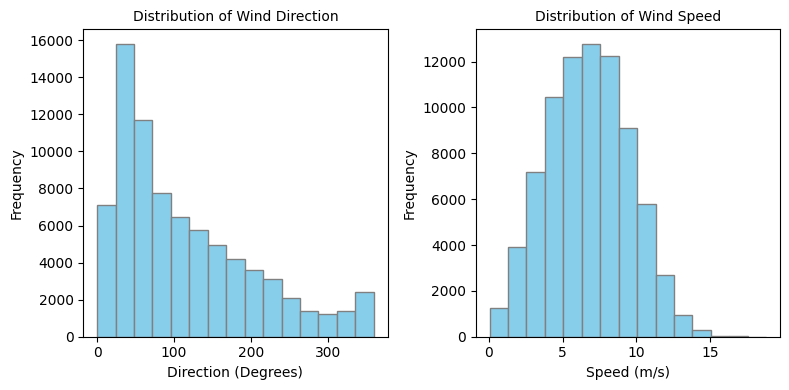

In [124]:
# plot data distribution
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))

#plot 1 - Wind Direction
ax1.hist(wind_df['wind_direction'], bins =15, color='skyblue', edgecolor = 'gray')
ax1.set_title('Distribution of Wind Direction', fontsize=10)
ax1.set_xlabel('Direction (Degrees)', fontsize=10)
ax1.set_ylabel('Frequency', fontsize=10)

# plot 2 - Wind Speed
ax2.hist(wind_df['wind_speed'], bins=15, color='skyblue', edgecolor= 'gray')
ax2.set_title('Distribution of Wind Speed', fontsize=10)
ax2.set_xlabel('Speed (m/s)', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)

# Optimization
plt.tight_layout() # Prevents labels from overlapping
plt.show()

In [120]:
q99_wind = wind_df['wind_speed'].quantile(0.99)
print(f'the 99th percentile: {q99_wind:.2f} m/s')
print(f'the threshold was exceeded {wind_df[wind_df["wind_speed"] > q99_wind].shape[0]} times.')
print(f'it represents {wind_df[wind_df["wind_speed"] > q99_wind].shape[0] / wind_df.shape[0] * 100:.2f}% of the total data.')
print(f'Date of highest wind speed: {wind_df["wind_speed"].idxmax()} with {wind_df["wind_speed"].max():.2f} m/s')

the 99th percentile: 13.03 m/s
the threshold was exceeded 790 times.
it represents 1.00% of the total data.
Date of highest wind speed: 2022-05-18 21:00:00 with 18.81 m/s


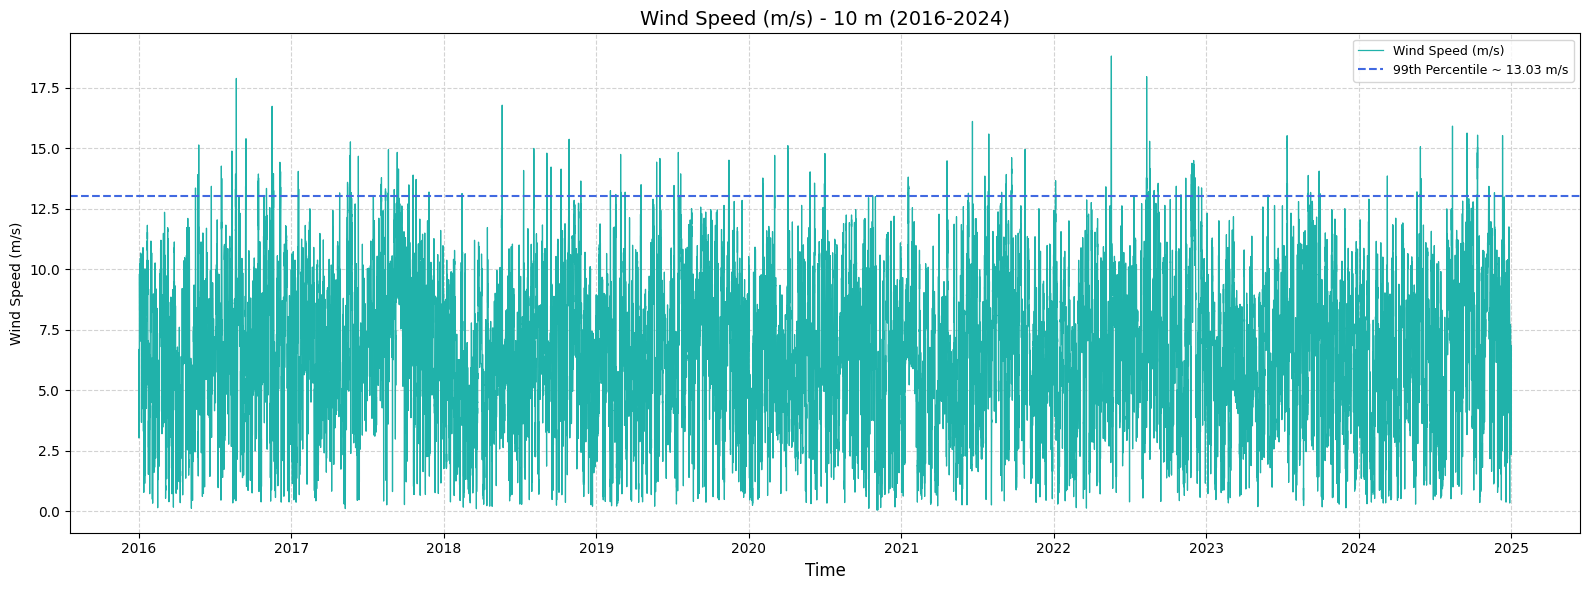

In [123]:
# plot wind speed time series
plt.figure(figsize=(16, 6))
plt.plot(wind_df.index, wind_df['wind_speed'], label='Wind Speed (m/s)', color='lightseagreen', linewidth=0.9)
plt.axhline(y=q99_wind, color='royalblue', linestyle='--', label=f'99th Percentile ~ {q99_wind:.2f} m/s')
plt.title('Wind Speed (m/s) - 10 m (2016-2024)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Wind Speed (m/s)')
plt.grid(
    linestyle = '--',
    color = 'lightgray'
)
plt.legend(loc = 'upper right',
           fontsize= 9)
plt.tight_layout()
plt.show()

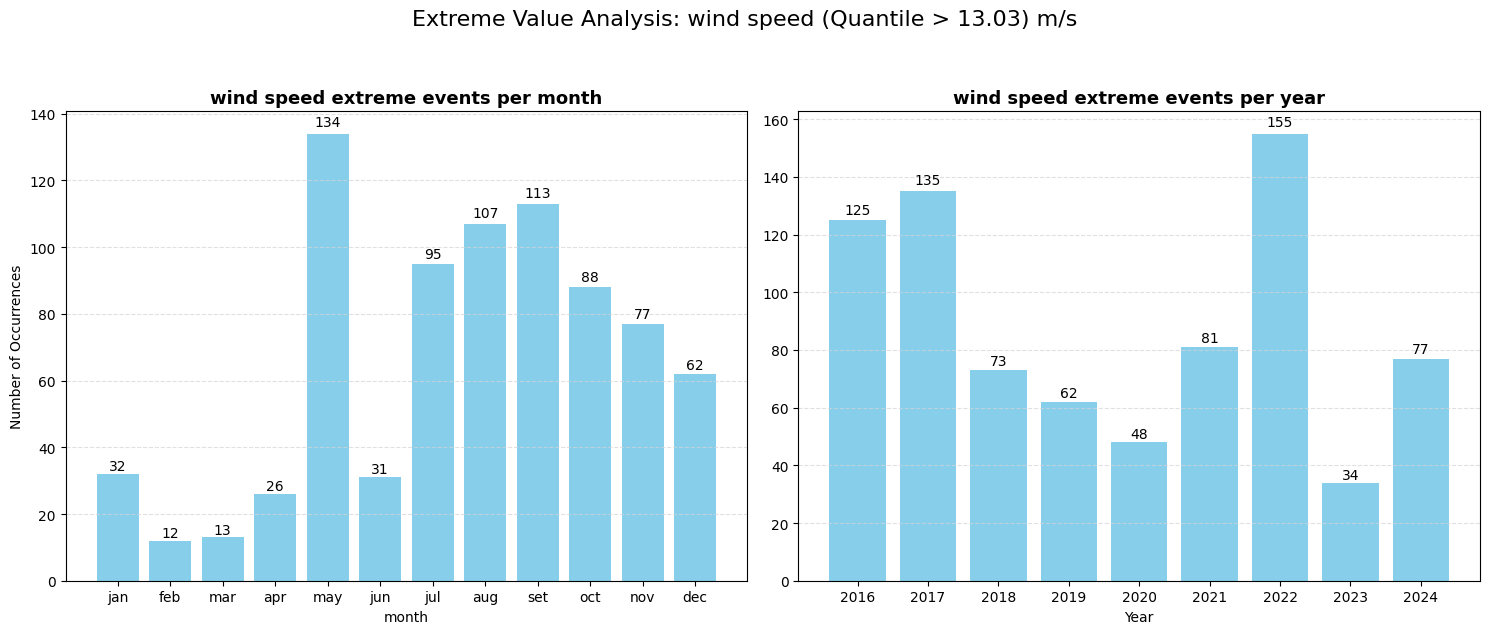

In [125]:
plot_extreme_events(wind_df, 'wind_speed', q99_wind, 'wind speed')

### plot windrose for general wind data (10 m)

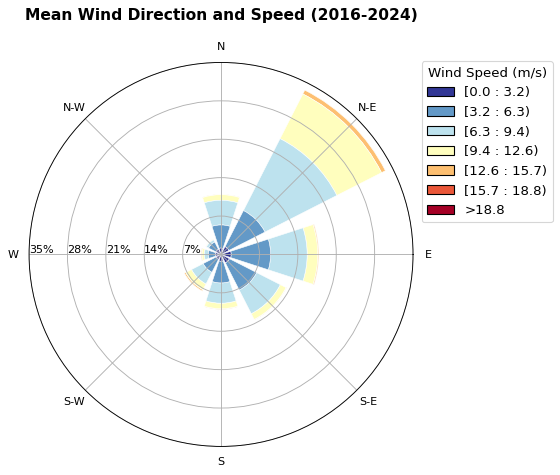

In [134]:
# plot wind roseplot
ax = windrose.WindroseAxes.from_ax(figsize=(6,6))
ax.bar(
    wind_df['wind_direction'],
    wind_df['wind_speed'],
    bins=7,
    nsector=8,
    normed=True,
    opening=0.8,
    edgecolor='white',
    linewidth=0.5,
    cmap=plt.cm.RdYlBu_r
)
legend = ax.set_legend(title='Wind Speed (m/s)',
              loc='upper right',
                bbox_to_anchor=(1.36, 1),
                fontsize=12)
plt.setp(legend.get_title(), fontsize=12) # Adjust legend title font size
# set legend text font size
for text in legend.get_texts():
    text.set_fontsize(12)
ax.set_rlabel_position(180)
ax.set_yticks([7, 14, 21, 28, 35])
ax.yaxis.set_major_formatter(tkr.FormatStrFormatter('%.0f%%')) # adds the % symbol
# set title
ax.set_title('Mean Wind Direction and Speed (2016-2024)', weight='bold', pad=20, fontsize=14)
plt.show()

### calculate limiar to define extreme events

In [136]:
# calculate extreme winds (99th percentile)
extreme_wind_df = wind_df[wind_df['wind_speed'] >= q99_wind] # filtering extreme winds

# basic statistics
max_w_speed = extreme_wind_df['wind_speed'].max()
min_w_speed = extreme_wind_df['wind_speed'].min()
mean_wind_speed = extreme_wind_df['wind_speed'].mean()
diference_wind_speed = max_w_speed - min_w_speed

print(f"Max Wind Speed: {max_w_speed:.2f} m/s")
print(f"Min Wind Speed: {min_w_speed:.2f} m/s")
print(f"Mean Wind Speed: {mean_wind_speed:.2f} m/s")
print(f"Difference Wind Speed: {diference_wind_speed:.2f} m/s")

Max Wind Speed: 18.81 m/s
Min Wind Speed: 13.03 m/s
Mean Wind Speed: 13.93 m/s
Difference Wind Speed: 5.78 m/s


Text(0, 0.5, 'Wind Speed (m/s)')

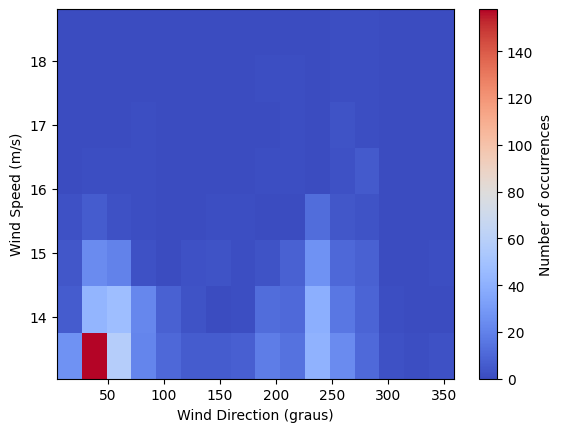

In [137]:
plt.hist2d(extreme_wind_df['wind_direction'], extreme_wind_df['wind_speed'],
           bins=[16, 8],
           cmap='coolwarm'
              )
plt.colorbar(label='Number of occurrences')
plt.xlabel('Wind Direction (graus)')
plt.ylabel('Wind Speed (m/s)')


Text(0.5, 1.0, 'Extreme Wind: Direction and Speed (2016-2024)')

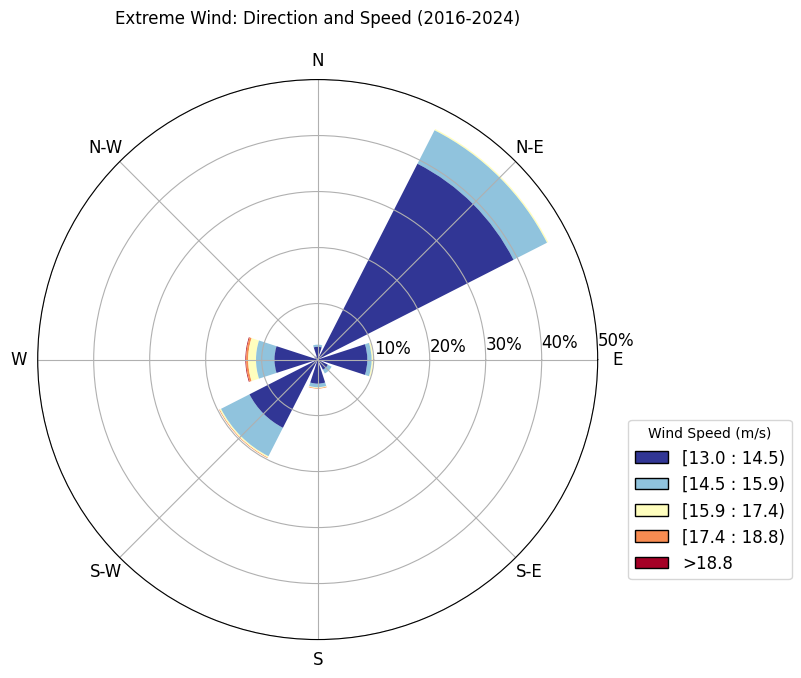

In [141]:
# plot widrose for extreme winds
fig = plt.figure(figsize=(7,7))
right_rectangle = [0,0,0.8,0.8] # [left, bottom, width, height]
ax = WindroseAxes(fig, right_rectangle)
fig.add_axes(ax)

ax.bar(extreme_wind_df['wind_direction'], extreme_wind_df['wind_speed'], # direction, magnitude
        normed=True, bins = 5, nsector=8,
        cmap = plt.get_cmap('RdYlBu_r'))
ax.tick_params(axis='both', which='major', labelsize=12)
# radial labels formatting
ax.legend(loc= 'center left', decimal_places=1, title="Wind Speed (m/s)",
          bbox_to_anchor=(1.04, 0.25), fontsize=12)
ax.set_rlabel_position(2) # radial label position
ax.set_yticks([10, 20, 30, 40, 50])
ax.yaxis.set_major_formatter(tkr.FormatStrFormatter('%.0f%%'))
plt.title("Extreme Wind: Direction and Speed (2016-2024)",pad= 20, fontsize=12)

### separate data per season

In [144]:
extreme_wind_df['season'] = extreme_wind_df.index.to_series().apply(define_season)

wind_summer = extreme_wind_df[extreme_wind_df['season'] == 'summer']
wind_autumn = extreme_wind_df[extreme_wind_df['season'] == 'autumn']
wind_winter = extreme_wind_df[extreme_wind_df['season'] == 'winter']
wind_spring = extreme_wind_df[extreme_wind_df['season'] == 'spring']

C:\Users\locfa\AppData\Local\Temp\ipykernel_33340\2732050961.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extreme_wind_df['season'] = extreme_wind_df.index.to_series().apply(define_season)


In [145]:
seasons = {'Summer': wind_summer, 'Autumn': wind_autumn, 'Winter': wind_winter, 'Spring': wind_spring}
for s in seasons:
    print(f"{s} - Maximum wind speed (m/s): {seasons[s]['wind_speed'].max()}")

Summer - Maximum wind speed (m/s): 14.74380874633789
Autumn - Maximum wind speed (m/s): 18.809511184692383
Winter - Maximum wind speed (m/s): 17.959579467773438
Spring - Maximum wind speed (m/s): 16.7319278717041


#### plt windrose per seasons

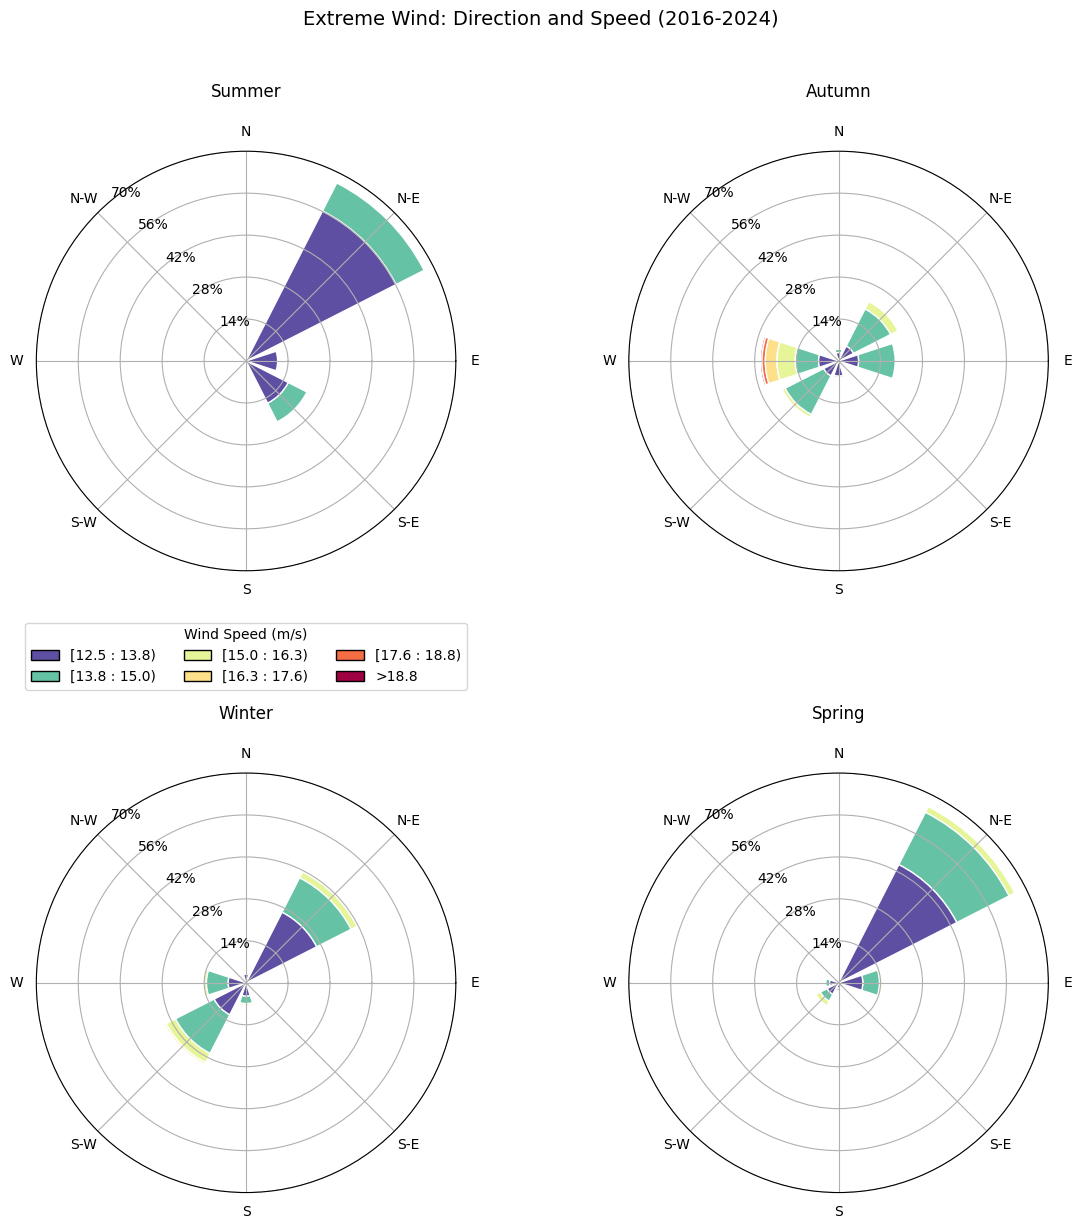

In [160]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), subplot_kw=dict(projection='windrose'))
seasons = {'Summer': wind_summer, 'Autumn': wind_autumn, 'Winter': wind_winter, 'Spring': wind_spring}
bins = np.linspace(min_w_speed-0.5, max_w_speed, num=6)
# --- STANDARDIZATION CONFIGURATION ---
# Define the maximum value of the radial scale (e.g., 25%).
r_max_limit = 70
# Define where the circles (grids) should appear
r_ticks = [14, 28, 42, 56, 70]

for i, (season, data) in enumerate(seasons.items()):
    ax = axes.flatten()[i]
    
    ax.bar(data['wind_direction'], data['wind_speed'],
           bins=bins,
           normed=True, # Ensures the calculation is in percentage.
           nsector=8,
           edgecolor='white', 
           cmap=cm.Spectral_r)
    
    ax.set_title(season, fontsize=12, pad=20)
    
    # Standardization of radial limits and ticks
    ax.set_ylim(0, r_max_limit) # Forces all axes to have the same size
    ax.set_yticks(r_ticks)      # Forces the same grid lines
    
    # Formatting of labels
    ax.set_rlabel_position(130)
    ax.yaxis.set_major_formatter(tkr.FormatStrFormatter('%2.0f%%')) # Adds the % symbol
# Adjustment of the legend (moved outside to avoid overlap)
axes.flatten()[0].legend(title="Wind Speed (m/s)",
                            loc='lower center', 
                            bbox_to_anchor=(0.5, -0.3), 
                            ncol=3)
fig.suptitle('Extreme Wind: Direction and Speed (2016-2024)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# identify exceding peaks over the threshold

this section will be used to identify peaks over thresholds, quantify and analyse their dependency

## sea water velocity

time resolution: 24 hours
Consider distinct peak events with a period between them greater than 24 hours.

In [174]:
# quantify peaks in current speed data 
from scipy.signal import find_peaks 
x = current_15m_df['current_speed'].to_numpy()

peaks, props = find_peaks(
    x,
    height = q_95, # peaks must be higher than 95th percentile
    distance = 2   # at least 2 samples apart => at least 48h apart
)

print(f"{len(peaks)} peaks found in current speed data above {q_95:.2f} m/s.")

51 peaks found in current speed data above 0.46 m/s.


## wind speed

wind dataframe has hour resolution 
so, to consider 24 hour period between peaks 

In [ ]:
x = wind_df['wind_speed'].to_numpy()
peaks, props = find_peaks(
    x,
    height = q99_wind, # peaks must be higher than 99th percentile
    distance = 48   # at least 24 samples apart => at least 24h apart
)


print(f"{len(peaks)} distinct peak wind events above {q99_wind:.2f} m/s were detected .")

111 distinct peak wind events above 13.03 m/s were detected .


## Significant Wave Height

wave dataframe has hourly resolution 
so, to consider 24 hour period between peaks 

In [ ]:
x = wave_df['swh'].to_numpy()
peaks, props = find_peaks(
    x,
    height = q99_Hs, # peaks must be higher than 99th percentile
    distance = 24   # at least 24 samples apart => at least 24h apart
)

print(f"{len(peaks)} distinct peak wave height events above {q99_Hs:.2f} m were detected .")

49 distinct peak wave height events above 3.94 m were detected .
